In [22]:
fdir = "../scripts/hanglog/junk1"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

logfiles = os.listdir(fdir)
print(logfiles)
fLog = os.path.join(fdir, logfiles[0])
fd = loaders.FlyDat(fLog)
fd.LoadC("ZY")

t0 = pandas.Timestamp('2020-12-26 17:48:31')
t1 = t0 + pandas.Timedelta("13s")

# later swing is better
t0 = pandas.Timestamp('2020-12-26 17:48:36')
t1 = t0 + pandas.Timedelta("8s")

pZ = fd.pZ[~fd.pZ.bad][t0:t1]

['hdata-2020-12-26_17-47-06.log']
Extracting knowndate from filename: 2020-12-26
badline End(17944,4948)

Y:8889, Z:9030, U:23, aF:300, aZ:310, aA:4337
linAdifftime 3669.815751445087 count 692
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2020-12-26 17:43:44.784816
Made for Z 9030 last index 9030
Warning, using guessed (not GPS) timing corrected value on Z 9030
pCattrname pZ
Made for Y 8889 last index 8889
Warning, using guessed (not GPS) timing corrected value on Y 8889
pCattrname pY


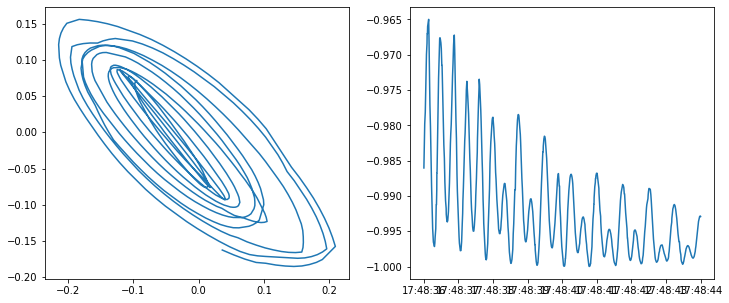

In [23]:
from hacktrack.utils import qvec, qmult, curvefitdifferentiate

a = (0,0,1)
rx, ry, rz = qvec((pZ.q0, pZ.q1, pZ.q2, pZ.q3), a)
plt.figure(figsize=(12,5))
fig = plt.subplot(121)
plt.plot(rx, ry)
fig = plt.subplot(122)
plt.plot(rz)


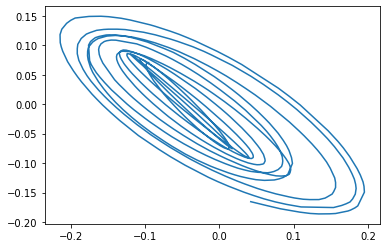

In [24]:
rx0, rx1, rx2 = curvefitdifferentiate(rx, 0.18)
ry0, ry1, ry2 = curvefitdifferentiate(ry, 0.18)
plt.plot(rx0, ry0)

pendulum length =  0.15436577741020313 m


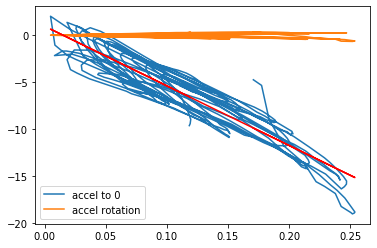

In [25]:
rxy2 = rx0**2 + ry0**2
rdot = rx0*rx2 + ry0*ry2
rdotperp = rx0*ry2 - ry0*rx2
rxylen = numpy.sqrt(rxy2)
rinwardacceleration = rdot/rxylen
plt.plot(rxylen, rinwardacceleration, label="accel to 0")
plt.plot(rxylen, rdotperp, label="accel rotation")

linear_model = numpy.polyfit(rxylen, rinwardacceleration, 1)
linear_model_fn = numpy.poly1d(linear_model)
plt.plot(rxylen, linear_model_fn(rxylen), color="red")
plt.legend()
print("pendulum length = ", -9.81/linear_model[0], "m")


In [ ]:
from hacktrack.utils import qvec, qmult, curvefitdifferentiate


In [6]:
from hacktrack.utils import qvec, qmult, curvefitdifferentiate

def fun(x):
    qa = (1,x[0],x[1],x[2])
    a = (0,0,1)
    rx, ry, rz = qvec(qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3)), a)
    res = sum(ry**2)
    return res
g = scipy.optimize.minimize(fun, (0,0,0), method="BFGS") 
g

      fun: 0.0033801492319821
 hess_inv: array([[ 0.00016705, -0.00012781,  0.00013899],
       [-0.00012781,  0.00075542,  0.00014482],
       [ 0.00013899,  0.00014482,  0.0304446 ]])
      jac: array([ 2.13563908e-06, -5.81319910e-07, -5.84986992e-09])
  message: 'Optimization terminated successfully.'
     nfev: 105
      nit: 9
     njev: 21
   status: 0
  success: True
        x: array([-0.00334966,  0.01027928,  0.82260538])

(-0.01554717941473504, 0.006090348938922435, 0.9998605867129919)


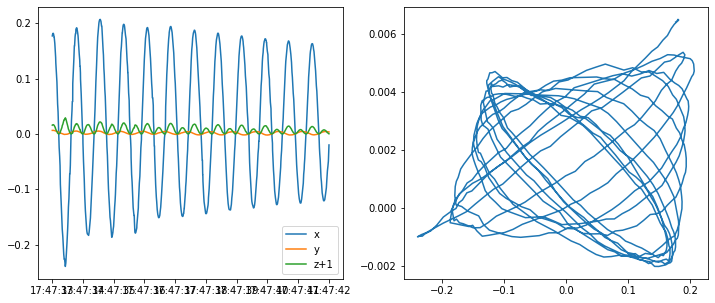

In [12]:
x = g.x
qa = (1,x[0],x[1],x[2])
a = qvec(qa, (0,0,1))
print(a)
rx, ry, rz = qvec(qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3)), a)
plt.figure(figsize=(12,5))
fig = plt.subplot(121)
plt.plot(rx, label="x")
plt.plot(ry, label="y")
plt.plot(rz+1, label="z+1")
plt.legend()
fig = plt.subplot(122)
plt.plot(rx, ry)

In [63]:
qb = (1,0,-0.007,0)
rx, ry, rz = qvec(qmult(qb, qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3))), a)
rx0, rx1, rx2 = curvefitdifferentiate(rx, 0.18)

[-5.91681072e+01  5.43751100e-03]
x'' = -g sin(theta);  x = r sin(theta);  therefore  slope=-g/(pendulum length)
pendulum length =  0.1658215010141988 m
If the coordinate frame were properly centred, then this ratio could be determined at every timestep


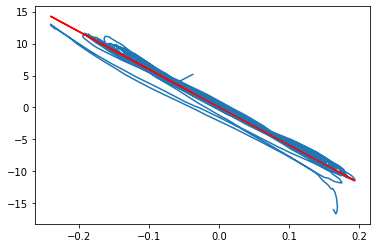

In [64]:
i0, i1 = 0, len(rx0)
plt.plot(rx0.iloc[i0:i1], rx2.iloc[i0:i1])
linear_model = numpy.polyfit(rx0,rx2,1)
linear_model_fn = numpy.poly1d(linear_model)
plt.plot(rx0, linear_model_fn(rx0), color="red")
print(linear_model)
print("x'' = -g sin(theta);  x = r sin(theta);  therefore  slope=-g/(pendulum length)")
print("pendulum length = ", 9.81/59.16, "m")
print("If the coordinate frame were properly centred, then this ratio could be determined at every timestep")

In [62]:
for b in numpy.linspace(-0.008,-0.006,11):
    qb = (1,0,b,0)
    rx, ry, rz = qvec(qmult(qb, qmult(qa, (pZ.q0, pZ.q1, pZ.q2, pZ.q3))), a)
    rx0, rx1, rx2 = curvefitdifferentiate(rx, 0.18)
    linear_model = numpy.polyfit(rx0,rx2,1)
    print(qb, linear_model)


(1, 0, -0.008, 0) [-59.16899215  -0.11206532]
(1, 0, -0.0078000000000000005, 0) [-59.16881506  -0.08856464]
(1, 0, -0.0076, 0) [-59.16863803  -0.06506401]
(1, 0, -0.0074, 0) [-5.91684610e+01 -4.15634357e-02]
(1, 0, -0.0072, 0) [-5.91682841e+01 -1.80629275e-02]
(1, 0, -0.007, 0) [-5.91681072e+01  5.43751100e-03]
(1, 0, -0.0068000000000000005, 0) [-5.91679304e+01  2.89378743e-02]
(1, 0, -0.0066, 0) [-5.91677537e+01  5.24381567e-02]
(1, 0, -0.0064, 0) [-59.16757694   0.07593835]
(1, 0, -0.0062, 0) [-59.16740027   0.09943846]
(1, 0, -0.006, 0) [-59.16722367   0.12293846]


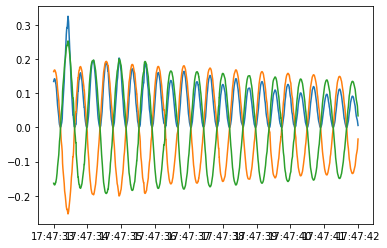

In [68]:
plt.plot((rz+1)*10)
plt.plot(rx)
plt.plot(-rx)


In [ ]:
# x'' = -g sin(theta);  
# x = r sin(theta);  therefore  slope=-g/(pendulum length)")
